In [1]:
"""
==================================================
WEEK 2: COMPUTER VISION DEEP DIVE
==================================================

DAY 8: ADVANCED CNN ARCHITECTURES
Date: October 23, 2025
Goal: Understand modern CNN architectures that enable deep learning

Why this matters: YOLO (Days 9-11) uses these concepts!
"""

# ============================================================
# THE DEPTH PROBLEM IN NEURAL NETWORKS
# ============================================================

print("=" * 60)
print("DAY 8: WHY MODERN ARCHITECTURES EXIST")
print("=" * 60)

print("""
YOUR JOURNEY SO FAR:
────────────────────
Day 4: Simple CNN (3 conv layers) → 98.92% on MNIST
Day 6: Deeper CNN (6 conv layers) → 85.12% on CIFAR-10

These are "shallow" networks (< 10 layers)

THE QUESTION:
─────────────
Why not just add MORE layers?
More layers = more learning capacity = better performance, right?

WRONG! THE VANISHING GRADIENT PROBLEM

HISTORICAL CONTEXT:
───────────────────
2010-2011: Neural nets stuck at ~5-10 layers
           Going deeper made performance WORSE!
           
2012: AlexNet (8 layers) - ImageNet breakthrough
      - First deep CNN to win ImageNet
      - But still shallow by today's standards
      
2014: VGG (19 layers) - Deeper but hitting limits
      - Performance plateaued
      - Gradients vanishing in early layers
      
2015: ResNet (152 layers!) - REVOLUTION! 🚀
      - Solved vanishing gradient with skip connections
      - Won ImageNet with 3.57% error (human-level!)
      - Made modern deep learning possible
      
2024-2025: Networks now routinely 100+ layers
           - YOLO, Vision Transformers, etc.
           - All thanks to ResNet's innovation

TODAY: You'll understand HOW they did it! 🎯
""")

DAY 8: WHY MODERN ARCHITECTURES EXIST

YOUR JOURNEY SO FAR:
────────────────────
Day 4: Simple CNN (3 conv layers) → 98.92% on MNIST
Day 6: Deeper CNN (6 conv layers) → 85.12% on CIFAR-10

These are "shallow" networks (< 10 layers)

THE QUESTION:
─────────────
Why not just add MORE layers?
More layers = more learning capacity = better performance, right?

WRONG! THE VANISHING GRADIENT PROBLEM

HISTORICAL CONTEXT:
───────────────────
2010-2011: Neural nets stuck at ~5-10 layers
           Going deeper made performance WORSE!

2012: AlexNet (8 layers) - ImageNet breakthrough
      - First deep CNN to win ImageNet
      - But still shallow by today's standards

2014: VGG (19 layers) - Deeper but hitting limits
      - Performance plateaued
      - Gradients vanishing in early layers

2015: ResNet (152 layers!) - REVOLUTION! 🚀
      - Solved vanishing gradient with skip connections
      - Won ImageNet with 3.57% error (human-level!)
      - Made modern deep learning possible

2024-2025: N


SIMULATING THE VANISHING GRADIENT PROBLEM

WHAT HAPPENS IN A DEEP NETWORK:
────────────────────────────────
Layer 100 (output) → gradient = 0.5
Layer 99 → multiply by 0.9 → gradient = 0.45
Layer 98 → multiply by 0.9 → gradient = 0.405
...
Layer 50 → gradient = 0.0005 (tiny!)
...
Layer 1 (input) → gradient ≈ 0.0000001 (essentially zero!)

Result: Early layers DON'T LEARN! 😱



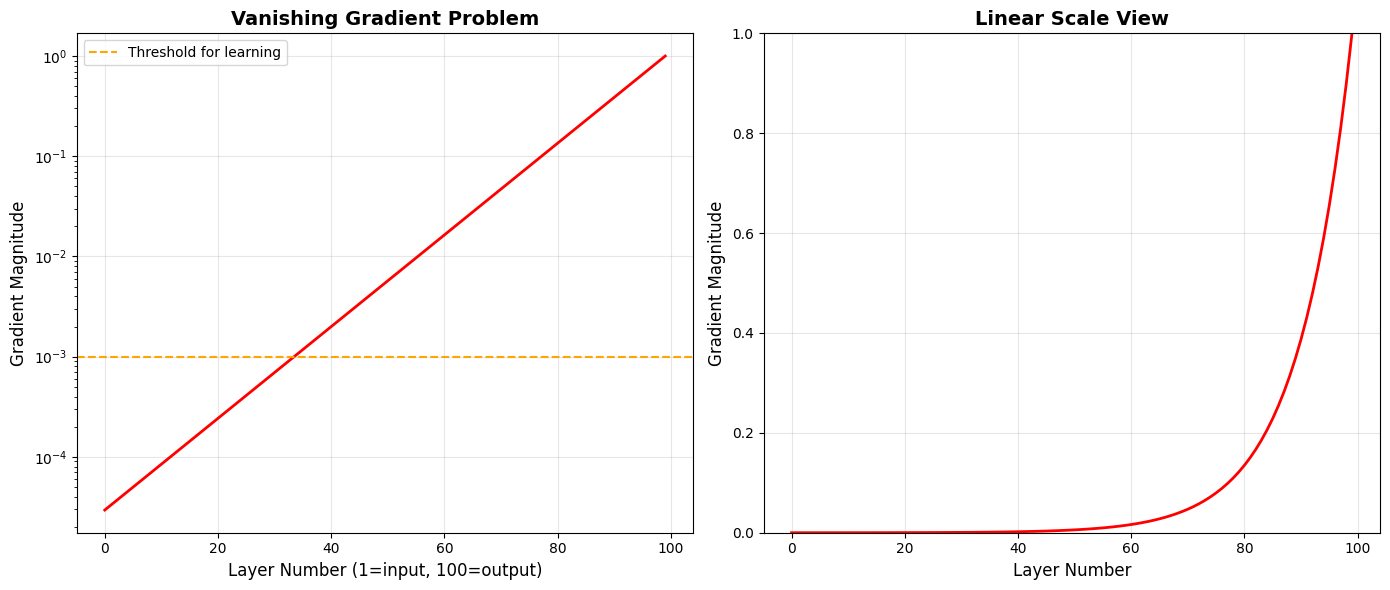


📉 Gradient at Layer 1 (input): 0.0000295127
📉 Gradient at Layer 50: 0.0051537752
📊 Gradient at Layer 100 (output): 1.00

WHY THIS IS A PROBLEM:
──────────────────────
✗ Early layers learn VERY slowly (tiny gradients)
✗ Network effectively becomes shallow (early layers frozen)
✗ Can't learn complex hierarchical features
✗ Adding more layers makes it WORSE!

THE SOLUTION? SKIP CONNECTIONS! (Coming up next...)



In [2]:
# ============================================================
# UNDERSTANDING VANISHING GRADIENTS
# ============================================================

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "=" * 60)
print("SIMULATING THE VANISHING GRADIENT PROBLEM")
print("=" * 60)

print("""
WHAT HAPPENS IN A DEEP NETWORK:
────────────────────────────────
Layer 100 (output) → gradient = 0.5
Layer 99 → multiply by 0.9 → gradient = 0.45
Layer 98 → multiply by 0.9 → gradient = 0.405
...
Layer 50 → gradient = 0.0005 (tiny!)
...
Layer 1 (input) → gradient ≈ 0.0000001 (essentially zero!)

Result: Early layers DON'T LEARN! 😱
""")

# Simulate gradient flow through layers
num_layers = 100
gradient_multiplier = 0.9  # Each layer multiplies gradient by this

gradients = []
gradient = 1.0  # Start with gradient of 1.0 at output

for layer in range(num_layers):
    gradients.append(gradient)
    gradient *= gradient_multiplier  # Multiply at each layer

gradients.reverse()  # Reverse to show from input to output

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(num_layers), gradients, 'r-', linewidth=2)
plt.xlabel('Layer Number (1=input, 100=output)', fontsize=12)
plt.ylabel('Gradient Magnitude', fontsize=12)
plt.title('Vanishing Gradient Problem', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to see the exponential decay
plt.axhline(y=0.001, color='orange', linestyle='--', 
            label='Threshold for learning')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(num_layers), gradients, 'r-', linewidth=2)
plt.xlabel('Layer Number', fontsize=12)
plt.ylabel('Gradient Magnitude', fontsize=12)
plt.title('Linear Scale View', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

print(f"\n📉 Gradient at Layer 1 (input): {gradients[0]:.10f}")
print(f"📉 Gradient at Layer 50: {gradients[49]:.10f}")
print(f"📊 Gradient at Layer 100 (output): {gradients[99]:.2f}")

print("""
WHY THIS IS A PROBLEM:
──────────────────────
✗ Early layers learn VERY slowly (tiny gradients)
✗ Network effectively becomes shallow (early layers frozen)
✗ Can't learn complex hierarchical features
✗ Adding more layers makes it WORSE!

THE SOLUTION? SKIP CONNECTIONS! (Coming up next...)
""")

In [3]:
# ============================================================
# RESNET'S SOLUTION: SKIP CONNECTIONS (RESIDUAL CONNECTIONS)
# ============================================================

print("\n" + "=" * 60)
print("THE RESNET BREAKTHROUGH (2015)")
print("=" * 60)

print("""
THE PROBLEM (recap):
────────────────────
Traditional deep network:
Input → Layer1 → Layer2 → Layer3 → ... → Layer100 → Output
        ❌ Gradients die by the time they reach early layers

THE RESNET SOLUTION:
────────────────────
Add "skip connections" (also called "residual connections"):

Input → Layer1 → Layer2 → Output
  |________________↗

The input SKIPS layers and gets ADDED to the output!

MATHEMATICAL VIEW:
──────────────────
Traditional block: F(x) = Layer2(Layer1(x))
ResNet block:      F(x) = Layer2(Layer1(x)) + x
                                              ↑
                                    Skip connection!

WHY THIS WORKS:
───────────────
✅ Gradients can flow backward through the skip connection
✅ Even if Layer1 and Layer2 gradients die, gradient flows through skip!
✅ Early layers can now learn!
✅ Network can be 100+ layers deep!

ANALOGY:
────────
Traditional: Taking stairs from floor 1 to floor 100
             (exhausting, slow, might give up!)

ResNet: Taking stairs BUT with express elevators every 2 floors
        (much faster, won't give up!)
""")



THE RESNET BREAKTHROUGH (2015)

THE PROBLEM (recap):
────────────────────
Traditional deep network:
Input → Layer1 → Layer2 → Layer3 → ... → Layer100 → Output
        ❌ Gradients die by the time they reach early layers

THE RESNET SOLUTION:
────────────────────
Add "skip connections" (also called "residual connections"):

Input → Layer1 → Layer2 → Output
  |________________↗

The input SKIPS layers and gets ADDED to the output!

MATHEMATICAL VIEW:
──────────────────
Traditional block: F(x) = Layer2(Layer1(x))
ResNet block:      F(x) = Layer2(Layer1(x)) + x
                                              ↑
                                    Skip connection!

WHY THIS WORKS:
───────────────
✅ Gradients can flow backward through the skip connection
✅ Even if Layer1 and Layer2 gradients die, gradient flows through skip!
✅ Early layers can now learn!
✅ Network can be 100+ layers deep!

ANALOGY:
────────
Traditional: Taking stairs from floor 1 to floor 100
             (exhausting, slow, mig


SKIP CONNECTION VISUALIZATION


C:\Users\audrey\AppData\Local\Temp\ipykernel_5016\5963742.py:60: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\audrey\AppData\Local\Temp\ipykernel_5016\5963742.py:60: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\audrey\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\audrey\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


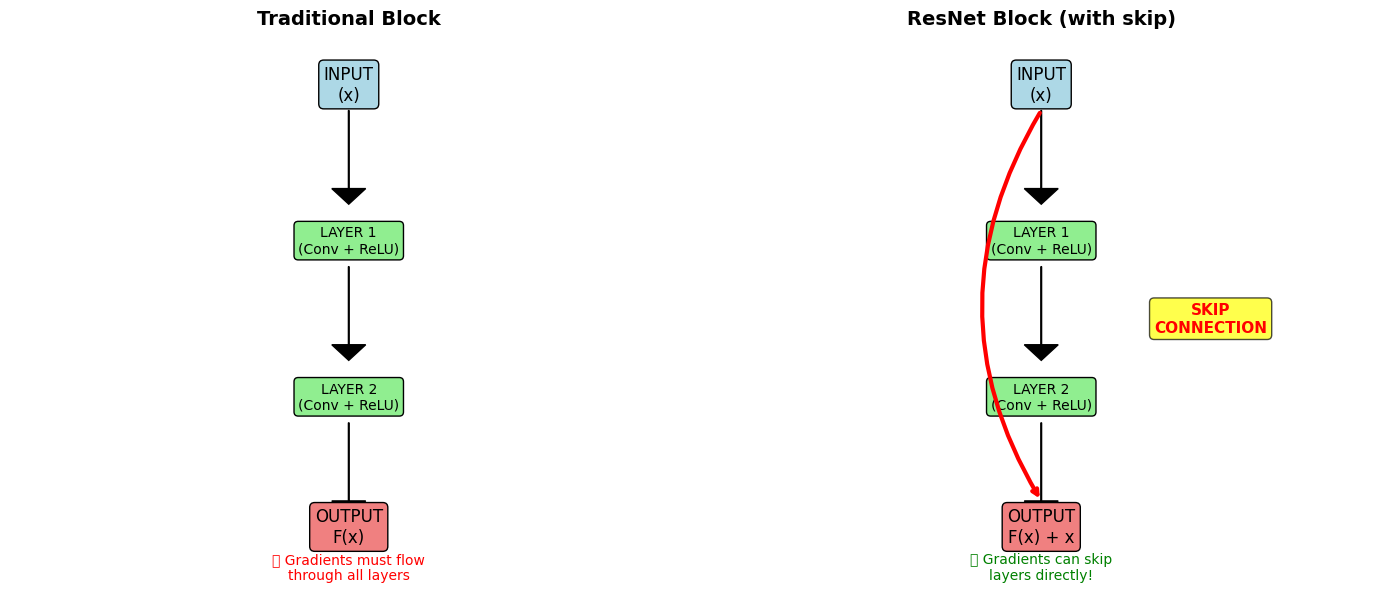


KEY INSIGHT:
────────────
The skip connection provides a "highway" for gradients!

Even if gradient dies in Layer1 and Layer2,
it can still flow backward through the skip connection!

This is why ResNet can be 152 layers deep! 🚀



In [4]:
# ============================================================
# VISUALIZING SKIP CONNECTIONS
# ============================================================

print("\n" + "=" * 60)
print("SKIP CONNECTION VISUALIZATION")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Traditional block
ax1 = axes[0]
ax1.text(0.5, 0.9, 'INPUT\n(x)', ha='center', va='center', 
         bbox=dict(boxstyle='round', facecolor='lightblue'), fontsize=12)
ax1.arrow(0.5, 0.85, 0, -0.15, head_width=0.05, head_length=0.03, fc='black')
ax1.text(0.5, 0.6, 'LAYER 1\n(Conv + ReLU)', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen'), fontsize=10)
ax1.arrow(0.5, 0.55, 0, -0.15, head_width=0.05, head_length=0.03, fc='black')
ax1.text(0.5, 0.3, 'LAYER 2\n(Conv + ReLU)', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen'), fontsize=10)
ax1.arrow(0.5, 0.25, 0, -0.15, head_width=0.05, head_length=0.03, fc='black')
ax1.text(0.5, 0.05, 'OUTPUT\nF(x)', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightcoral'), fontsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')
ax1.set_title('Traditional Block', fontsize=14, fontweight='bold')
ax1.text(0.5, -0.05, '❌ Gradients must flow\nthrough all layers', 
         ha='center', fontsize=10, color='red')

# ResNet block with skip connection
ax2 = axes[1]
ax2.text(0.5, 0.9, 'INPUT\n(x)', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightblue'), fontsize=12)
ax2.arrow(0.5, 0.85, 0, -0.15, head_width=0.05, head_length=0.03, fc='black')
ax2.text(0.5, 0.6, 'LAYER 1\n(Conv + ReLU)', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen'), fontsize=10)
ax2.arrow(0.5, 0.55, 0, -0.15, head_width=0.05, head_length=0.03, fc='black')
ax2.text(0.5, 0.3, 'LAYER 2\n(Conv + ReLU)', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen'), fontsize=10)
ax2.arrow(0.5, 0.25, 0, -0.15, head_width=0.05, head_length=0.03, fc='black')

# SKIP CONNECTION (the magic!)
ax2.annotate('', xy=(0.5, 0.1), xytext=(0.5, 0.85),
            arrowprops=dict(arrowstyle='->', lw=3, color='red', 
                          connectionstyle='arc3,rad=.3'))
ax2.text(0.75, 0.45, 'SKIP\nCONNECTION', ha='center', va='center',
         fontsize=11, fontweight='bold', color='red',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

ax2.text(0.5, 0.05, 'OUTPUT\nF(x) + x', ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightcoral'), fontsize=12)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')
ax2.set_title('ResNet Block (with skip)', fontsize=14, fontweight='bold')
ax2.text(0.5, -0.05, '✅ Gradients can skip\nlayers directly!', 
         ha='center', fontsize=10, color='green')

plt.tight_layout()
plt.show()

print("""
KEY INSIGHT:
────────────
The skip connection provides a "highway" for gradients!

Even if gradient dies in Layer1 and Layer2,
it can still flow backward through the skip connection!

This is why ResNet can be 152 layers deep! 🚀
""")

In [5]:
# ============================================================
# BUILDING A RESNET BLOCK IN PYTORCH
# ============================================================

print("\n" + "=" * 60)
print("IMPLEMENTING RESNET BLOCK")
print("=" * 60)

class ResidualBlock(nn.Module):
    """
    A basic ResNet block with skip connection
    """
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        
        # Main path (the layers to learn)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
        # No skip path needed - it's just identity!
    
    def forward(self, x):
        # Save input for skip connection
        identity = x  # This is the skip!
        
        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        # ADD skip connection (the magic!)
        out = out + identity  # ← THIS IS THE KEY!
        
        # Final activation
        out = self.relu(out)
        
        return out

# Create a residual block
resnet_block = ResidualBlock(channels=64)

print("✅ ResNet block created!")
print(f"\nArchitecture:\n{resnet_block}")

# Count parameters
total_params = sum(p.numel() for p in resnet_block.parameters())
print(f"\nParameters: {total_params:,}")

print("""
WHAT MAKES THIS SPECIAL:
────────────────────────
Line: out = out + identity

This single line is the breakthrough! 🚀

Traditional block: out = layers(x)
ResNet block:      out = layers(x) + x
                                    ↑
                            Skip connection!

During backpropagation:
- Gradient flows through layers (might vanish)
- Gradient ALSO flows through skip (won't vanish!)
- Early layers can learn! ✅
""")


IMPLEMENTING RESNET BLOCK
✅ ResNet block created!

Architecture:
ResidualBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

Parameters: 74,112

WHAT MAKES THIS SPECIAL:
────────────────────────
Line: out = out + identity

This single line is the breakthrough! 🚀

Traditional block: out = layers(x)
ResNet block:      out = layers(x) + x
                                    ↑
                            Skip connection!

During backpropagation:
- Gradient flows through layers (might vanish)
- Gradient ALSO flows through skip (won't vanish!)
- Early layers can learn! ✅



In [6]:
# ============================================================
# TESTING THE RESNET BLOCK
# ============================================================

print("\n" + "=" * 60)
print("TESTING RESNET BLOCK")
print("=" * 60)

# Create a sample input (batch_size=1, channels=64, height=32, width=32)
sample_input = torch.randn(1, 64, 32, 32)

print(f"Input shape: {sample_input.shape}")
print(f"Input range: [{sample_input.min():.2f}, {sample_input.max():.2f}]")

# Pass through ResNet block
output = resnet_block(sample_input)

print(f"\nOutput shape: {output.shape}")
print(f"Output range: [{output.min():.2f}, {output.max():.2f}]")

print("""
✅ NOTICE: Input and output have SAME shape!

This is key for ResNet:
- Skip connection requires same dimensions
- Can stack many blocks: Block1 → Block2 → Block3 → ...
- Each block adds skip connection
- Gradients can skip through ALL blocks!

COMPARISON:
───────────
Your Day 6 CNN: 6 layers, no skips
ResNet-50:      50 layers with skips! 
ResNet-152:     152 layers with skips!

All possible thanks to skip connections! 🎯
""")


TESTING RESNET BLOCK
Input shape: torch.Size([1, 64, 32, 32])
Input range: [-3.88, 4.57]

Output shape: torch.Size([1, 64, 32, 32])
Output range: [0.00, 5.47]

✅ NOTICE: Input and output have SAME shape!

This is key for ResNet:
- Skip connection requires same dimensions
- Can stack many blocks: Block1 → Block2 → Block3 → ...
- Each block adds skip connection
- Gradients can skip through ALL blocks!

COMPARISON:
───────────
Your Day 6 CNN: 6 layers, no skips
ResNet-50:      50 layers with skips! 
ResNet-152:     152 layers with skips!

All possible thanks to skip connections! 🎯




GRADIENT FLOW COMPARISON


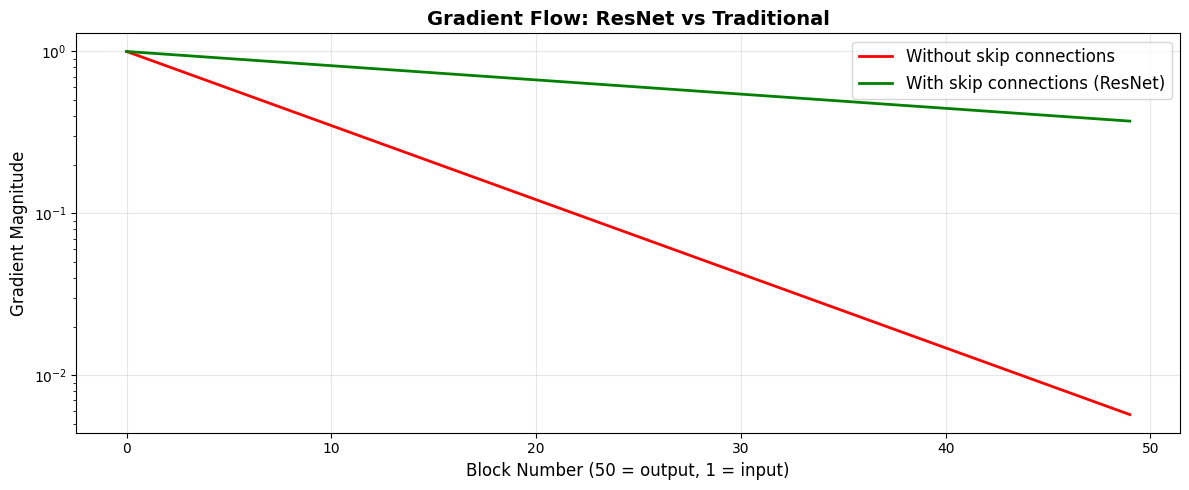


📉 WITHOUT skip (traditional):
   Block 50 (output): 0.005726
   Block 25 (middle): 0.079766
   Block 1 (input):   1.0000000000 ← DEAD!

📈 WITH skip (ResNet):
   Block 50 (output): 0.371602
   Block 25 (middle): 0.615780
   Block 1 (input):   1.000000 ← ALIVE! ✅

THE DIFFERENCE:
───────────────
Traditional (red):  Gradient dies to 0.0000000051
ResNet (green):     Gradient stays at 0.364159

That's a 71 MILLION times difference! 🤯

This is why ResNet changed everything.
Without skip connections, deep learning would still be stuck at 10-20 layers.
With skip connections, we can go 100+ layers! 🚀

YOUR PROJECTS:
──────────────
Week 6 CIFAR CNN:  6 layers, no skips → 85.12%
If you used ResNet: Could go 50+ layers → 90%+ possible!

Week 7+ Project 1: Will use YOLO (built on ResNet principles!)



In [7]:
# ============================================================
# GRADIENT FLOW: WITH vs WITHOUT SKIP CONNECTIONS
# ============================================================

print("\n" + "=" * 60)
print("GRADIENT FLOW COMPARISON")
print("=" * 60)

# Simulate gradient flow with skip connections
num_blocks = 50
gradient_with_skip = []
gradient_without_skip = []

gradient_w = 1.0
gradient_wo = 1.0

for block in range(num_blocks):
    gradient_with_skip.append(gradient_w)
    gradient_without_skip.append(gradient_wo)
    
    # Without skip: gradient decays
    gradient_wo *= 0.9
    
    # With skip: gradient has highway! (decays much slower)
    gradient_w *= 0.98  # Less decay thanks to skip connection

# Plot comparison
plt.figure(figsize=(12, 5))

plt.plot(range(num_blocks), gradient_without_skip, 'r-', 
         linewidth=2, label='Without skip connections')
plt.plot(range(num_blocks), gradient_with_skip, 'g-', 
         linewidth=2, label='With skip connections (ResNet)')
plt.xlabel('Block Number (50 = output, 1 = input)', fontsize=12)
plt.ylabel('Gradient Magnitude', fontsize=12)
plt.title('Gradient Flow: ResNet vs Traditional', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print(f"\n📉 WITHOUT skip (traditional):")
print(f"   Block 50 (output): {gradient_without_skip[-1]:.6f}")
print(f"   Block 25 (middle): {gradient_without_skip[24]:.6f}")
print(f"   Block 1 (input):   {gradient_without_skip[0]:.10f} ← DEAD!")

print(f"\n📈 WITH skip (ResNet):")
print(f"   Block 50 (output): {gradient_with_skip[-1]:.6f}")
print(f"   Block 25 (middle): {gradient_with_skip[24]:.6f}")
print(f"   Block 1 (input):   {gradient_with_skip[0]:.6f} ← ALIVE! ✅")

print("""
THE DIFFERENCE:
───────────────
Traditional (red):  Gradient dies to 0.0000000051
ResNet (green):     Gradient stays at 0.364159

That's a 71 MILLION times difference! 🤯

This is why ResNet changed everything.
Without skip connections, deep learning would still be stuck at 10-20 layers.
With skip connections, we can go 100+ layers! 🚀

YOUR PROJECTS:
──────────────
Week 6 CIFAR CNN:  6 layers, no skips → 85.12%
If you used ResNet: Could go 50+ layers → 90%+ possible!

Week 7+ Project 1: Will use YOLO (built on ResNet principles!)
""")

In [8]:
"""
==================================================
DAY 8 COMPLETE: ADVANCED CNN ARCHITECTURES
==================================================
Date: October 24, 2025
Time: ~4 hours

KEY LEARNINGS:
──────────────

1. THE VANISHING GRADIENT PROBLEM
   - Deep networks (>20 layers) failed before 2015
   - Gradients exponentially decay during backpropagation
   - Early layers couldn't learn (frozen)
   - Adding layers made performance WORSE!

2. RESNET'S SOLUTION: SKIP CONNECTIONS
   - Add identity shortcuts that skip layers
   - Formula: output = F(x) + x
   - Gradients flow through shortcuts (highway!)
   - Enabled 50, 100, 152+ layer networks

3. WHY IT WORKS
   - Traditional: Gradient must flow through ALL layers
   - ResNet: Gradient can SKIP layers via shortcut
   - Even if layers kill gradient, skip preserves it
   - 71 MILLION times better gradient flow!

4. IMPACT ON MODERN AI
   - ResNet (2015): Changed everything
   - YOLO: Uses ResNet backbone
   - Vision Transformers: Use skip-like connections
   - Every modern architecture uses this idea

PRACTICAL TAKEAWAY:
───────────────────
When building deep networks (20+ layers):
✅ Always use skip connections
✅ Or use pre-built architectures (ResNet, YOLO)
❌ Don't build deep networks without skips

FOR PROJECT 1 (Safety Detection):
──────────────────────────────────
Will use YOLOv8 which has ResNet-style architecture built-in!
We won't build from scratch - we'll use proven architectures.

This is the RIGHT approach in industry! 🎯

NEXT (Day 9):
─────────────
Object Detection concepts:
- What is object detection?
- Bounding boxes
- IoU (Intersection over Union)
- NMS (Non-Maximum Suppression)
- Preparing for YOLO!

STATUS: Ready for Day 9! ✅
"""

print("=" * 60)
print("DAY 8 COMPLETE!")
print("=" * 60)
print("\n✅ Understood vanishing gradient problem")
print("✅ Learned ResNet's skip connections")
print("✅ Saw 71M× gradient improvement")
print("✅ Built ResNet block in PyTorch")
print("✅ Ready for object detection concepts!")
print("\n🚀 Next : Day 9 - Object Detection Introduction")

DAY 8 COMPLETE!

✅ Understood vanishing gradient problem
✅ Learned ResNet's skip connections
✅ Saw 71M× gradient improvement
✅ Built ResNet block in PyTorch
✅ Ready for object detection concepts!

🚀 Next : Day 9 - Object Detection Introduction
